# Homework 2 : Data from the Web

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import scipy
import editdistance
from bs4 import BeautifulSoup

%matplotlib inline
sns.set_style("dark")
sns.set_palette("deep", 10)
sns.set(font_scale = 1.5)

# TODO : 
- add size of the countries, plot boxplots, country population - apparently something related to international students and faculty related to country size


# 1. Top University Ranking : QS
Next we Are going to load the data from the URL of QS. The main URL of the ranking page is the following : 

In [2]:
QS_base_URL = "https://www.topuniversities.com"
QS_data_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508016143198"

Nest, we make the HTTP Request and get the JSON file into a list of dictionnaries :

In [3]:
QS_R = requests.get(QS_data_URL)
QS_dict = QS_R.json()['data']
print("Number of universities :",len(QS_dict))
print(QS_dict[0])

Number of universities : 959
{'nid': '294850', 'url': '/universities/massachusetts-institute-technology-mit', 'title': 'Massachusetts Institute of Technology (MIT)', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">', 'core_id': '410', 'score': '100', 'rank_display': '1', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '6', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}


Create an empty dataFrame for the QS Data :

In [4]:
ranking_QS = pd.DataFrame(columns = ['Name','Rank','Country','Region',\
                                     'Number of faculty members (int)','Number of faculty members (total)',\
                                     'Number of students (int)','Number of students (total)'])

We created the following functions. 

The first function takes a beautiful soup and extracts a specific class which it converts from string to int. 

The second function takes in input the ranking dataframe and the dictionnary of the i_th university. The aim of this function is to go look for the missing information which are in the page of the university. 

In [5]:
def get_specific_info(soup, class_):
    try: 
        info = str(soup.find('div', class_= class_).string)
        info = int(info.replace(',',''))
    except:
        info = np.nan
    return info

def get_additional_info(university_dict):
    QS_univ_URL = QS_base_URL + university_dict['url'] # this URL contains additional information that we will extract
    QS_univ_r = requests.get(QS_univ_URL)
    QS_univ_s = BeautifulSoup(QS_univ_r.text,'html.parser')
    
    ### getting info on the faculty members : 
    faculty_int_s = QS_univ_s.find('div', class_= 'inter faculty')
    faculty_total_s = QS_univ_s.find('div', class_= 'total faculty')

    faculty_members = {'In total': get_specific_info(faculty_total_s, 'number'),\
                       'International': get_specific_info(faculty_int_s, 'number')}
    
    ### getting info on the students
    student_total_s = QS_univ_s.find('div', class_= 'total student')
    student_int_s = QS_univ_s.find('div', class_= 'int-students-main')
    
    students = {'In total': get_specific_info(student_total_s, 'number') ,\
                'International': get_specific_info(student_int_s, 'number')}

    return faculty_members,students

The following code allows us to get all the information for the `n_univ` first universities, from the list of dicitonnaries `QS_dict`, and from the university website through the previous function `get_additional_info()`. All this information is set in the previous dataframe  As there are some universities that don't have the information for international faculty member, we decide to add a NaN value. 

In [6]:
n_univ = 201;
for i in range(n_univ):
    univ = QS_dict[i]
    ### Go get the missing information on the page of the univerisity
    [faculty_members,students] = get_additional_info(univ)
    
    ### create the new line of the Dataframe ranking_QS
    univ_data = [ univ['title'],univ['rank_display'].replace('=', ''),univ['country'],univ['region'],\
                      faculty_members['International'], faculty_members['In total'],\
                       students['International'], students['In total']]
    ranking_QS.loc[i] = univ_data
    

Now that we have the dataframe `ranking_QS`, we need to clean a little bit the data and convert into numbers the columns that are in strings

Note that we removed the =XXX in the `Rank` column when 2 universities have the same rank in previous cell

In [7]:
# converting the following columns to int : 
conv_2_int = ['Number of faculty members (int)','Number of faculty members (total)',\
              'Number of students (int)','Number of students (total)', 'Rank']

ranking_QS[conv_2_int] = ranking_QS[conv_2_int].apply(pd.to_numeric)

# display the cleaned dataframe
ranking_QS.head()

,Name,Rank,Country,Region,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total)
0,Massachusetts Institute of Technology (MIT),1,United States,North America,1679.0,2982.0,3717.0,11067.0
1,Stanford University,2,United States,North America,2042.0,4285.0,3611.0,15878.0
2,Harvard University,3,United States,North America,1311.0,4350.0,5266.0,22429.0
3,California Institute of Technology (Caltech),4,United States,North America,350.0,953.0,647.0,2255.0
4,University of Cambridge,5,United Kingdom,Europe,2278.0,5490.0,6699.0,18770.0


Now we have our clean dataframe and we can compute the asked values : 

### 1.a. Ratio between faculty members and students and ranking accordingly

In [8]:
ranking_QS['Ratio Faculty/Students'] = ranking_QS['Number of faculty members (total)']\
                                       /ranking_QS['Number of students (total)']
ratio_fac_students = ranking_QS[['Name', 'Ratio Faculty/Students']].sort_values('Ratio Faculty/Students',ascending=False)
ratio_fac_students.set_index('Name', inplace = True)

### 1.b.  Ratio of international students and ranking accordingly

In [9]:
ranking_QS['Ratio Int/Total Students'] = ranking_QS['Number of students (int)']/ranking_QS['Number of students (total)']
ratio_int_students = ranking_QS[['Name', 'Ratio Int/Total Students']].sort_values('Ratio Int/Total Students',ascending=False)
ratio_int_students.set_index('Name', inplace = True)

### 1.c. By country : average ratio of international students and  ratio between faculty members and students 
### TODO : ask if average by country or sorting by country

We are going to display the same statistic but for each country. We only consider the Top 10 countries here sorted by the desired criterion

In [10]:
# Ratio of international students by country
country_rank_int_total_students = ranking_QS.groupby('Country').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
# Ratio between faculty members and students by country
country_rank_fac_students= ranking_QS.groupby('Country').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]

### 1.d. By region : average ratio of international students and  ratio between faculty members and students
### TODO : ask if average by region or sorting by region
We are going to display the same statistic but for each region. As we have 6 regions, we display the whole ranking.

In [11]:
# Ratio of international students by region
region_int_total_students = ranking_QS.groupby('Region').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
# Ratio between faculty members and students by region
region_fac_students = ranking_QS.groupby('Region').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]

## 1.2. Bar Plots

The idea here is that we do not want to plot the ratio of of international vs total students as well as faculty vs. students. As there are 200 universities there were three possibilites : 
- plot everything but that would be impossible to read
- plot just a portion so either the first 40 for example but then we would loose the overall trend or just take a random portion and plot it. Neither are optimal or representative of the entire dataset
- group the universities into bins of 10 based on rank and compute the average ratio. Then do the barplot with that information. 

We chose to plot the top 50 and do the latter as we thought it offered the best compromise between visualizing all relative information without ignoring certain universities. We could also compare which universities were in the top 50 of both rankings. 

The function in the following cell can therefore be used to split the data based on the index into num_bins columns and then plotting the desired column as a searborn barplot

In [12]:
def plot_groupby_rank(num_bins, df, info):
    bins = [i*num_bins for i in range(n_univ//num_bins + 1)]
    bin_labels = ['['+str((i)*num_bins)+':'+str((i+1)*num_bins)+']' for i in range(n_univ//num_bins)]
    df = df.groupby(pd.cut(df.reset_index().index,bins=bins ,labels=bin_labels)).mean().copy()
    plot = sns.barplot(df.index,df[info])
    plot.set_xticklabels(df.index,rotation=90)

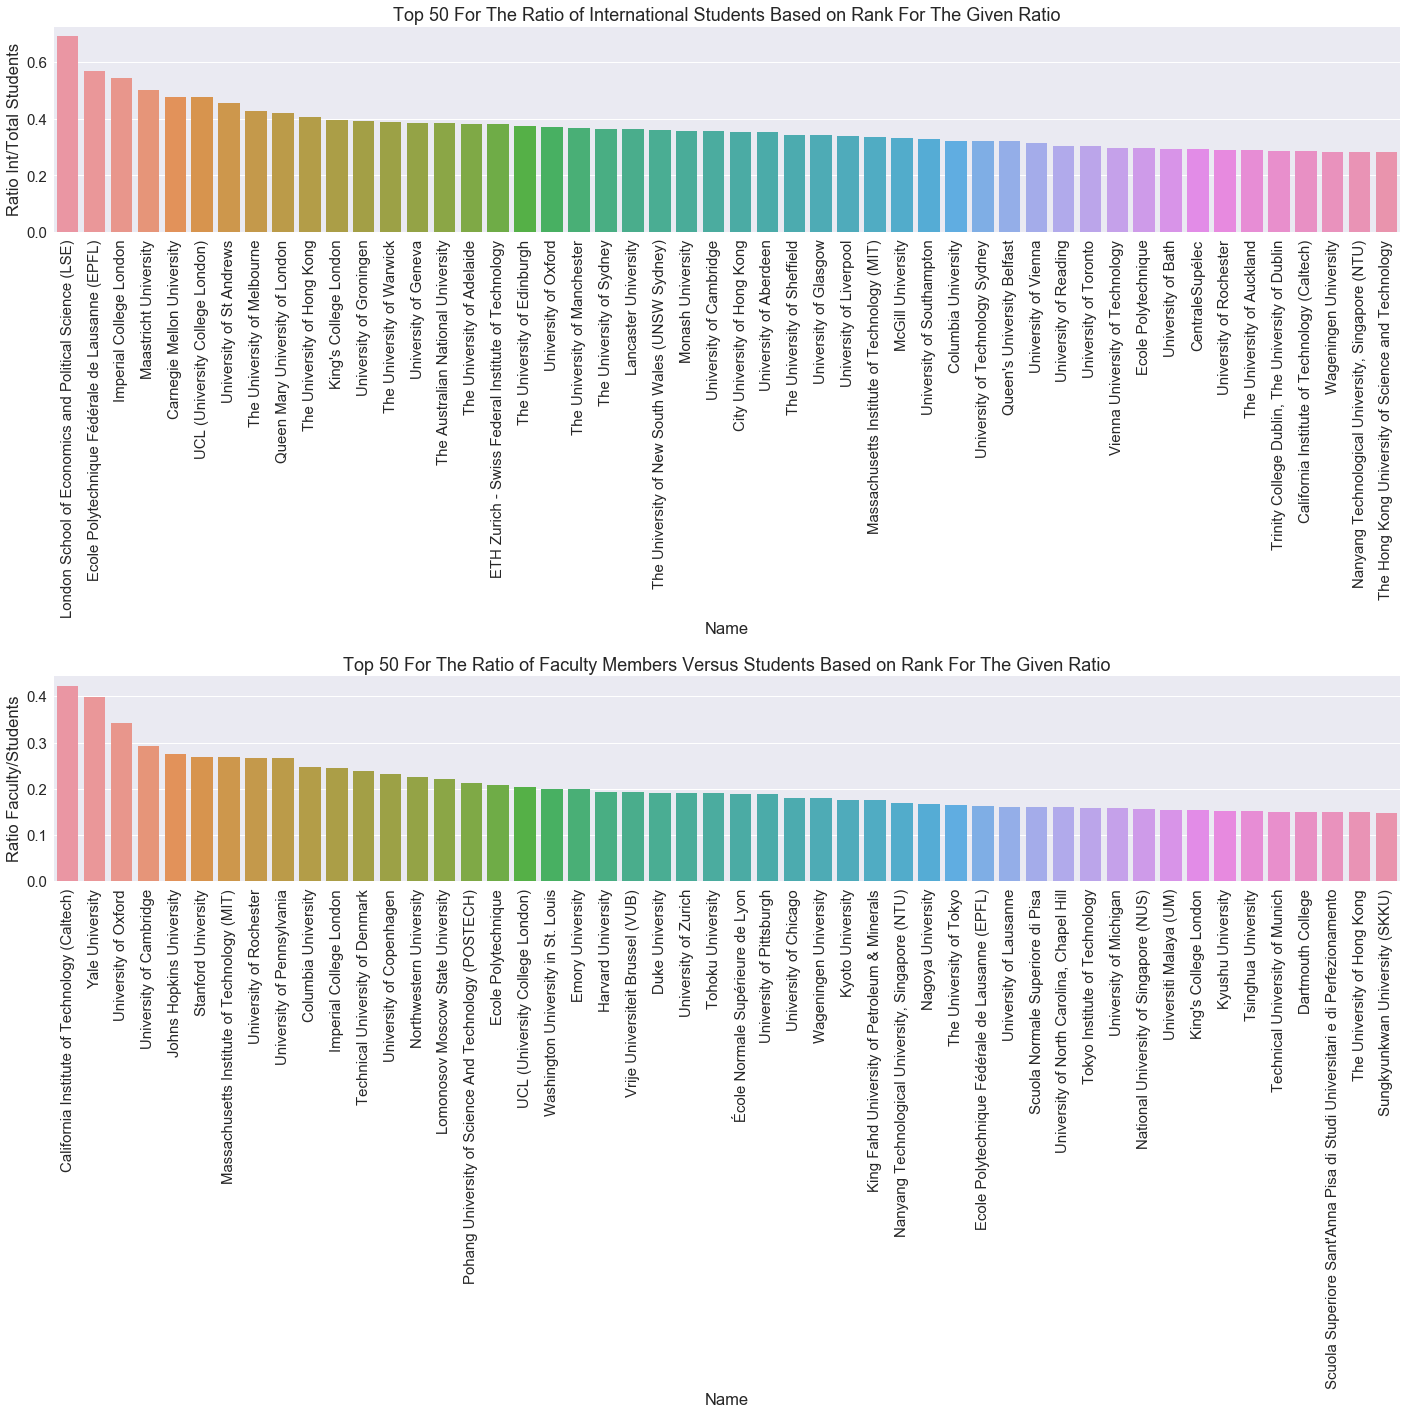

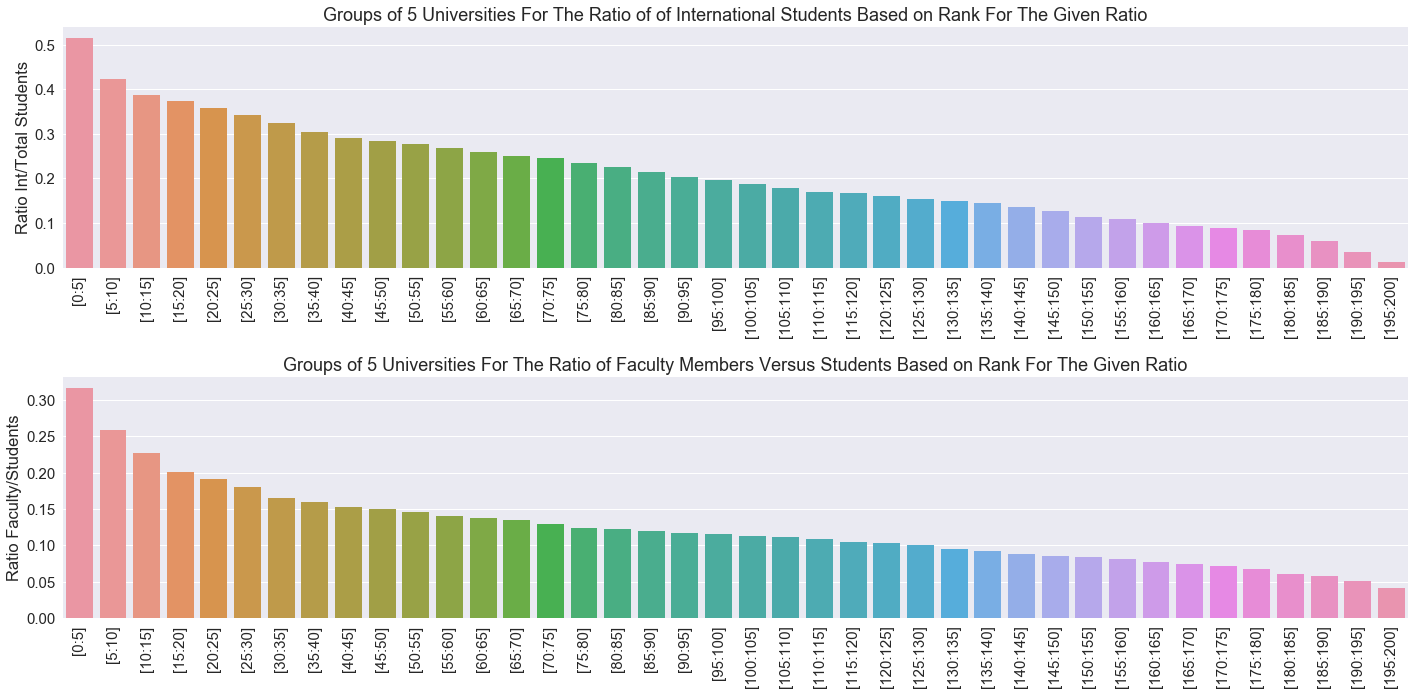

In [13]:
fig = plt.figure(figsize  = (20,20))

plt.subplot(211)
plot = sns.barplot(ratio_int_students.head(50).index,ratio_int_students['Ratio Int/Total Students'].head(50))
plot.set_xticklabels(ratio_int_students.index,rotation=90)
plt.title("Top 50 For The Ratio of International Students Based on Rank For The Given Ratio")

plt.subplot(212)
plot = sns.barplot(ratio_fac_students.head(50).index,ratio_fac_students['Ratio Faculty/Students'].head(50))
plot.set_xticklabels(ratio_fac_students.index,rotation=90)
plt.title("Top 50 For The Ratio of Faculty Members Versus Students Based on Rank For The Given Ratio")

fig.tight_layout()


fig = plt.figure(figsize  = (20,10))

plt.subplot(211)
plot_groupby_rank(5, ratio_int_students,'Ratio Int/Total Students')
plt.title("Groups of 5 Universities For The Ratio of of International Students Based on Rank For The Given Ratio")

plt.subplot(212)
plot_groupby_rank(5, ratio_fac_students,'Ratio Faculty/Students')
plt.title("Groups of 5 Universities For The Ratio of Faculty Members Versus Students Based on Rank For The Given Ratio")

fig.tight_layout()

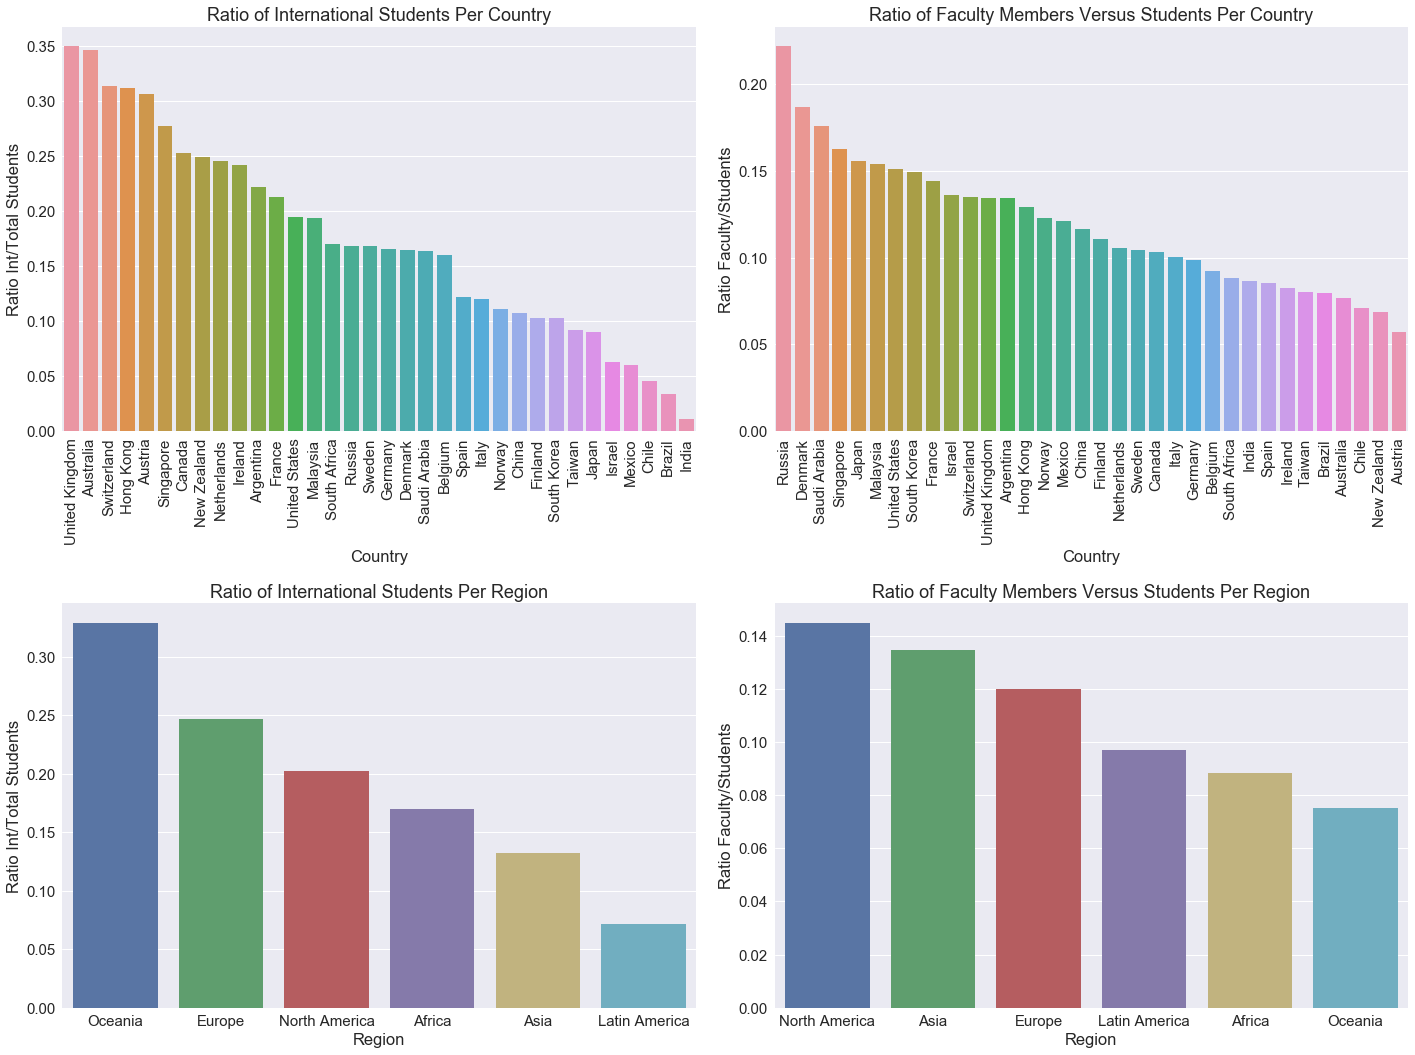

In [14]:
fig = plt.figure(figsize  = (20,15))
plt.subplot(221)
plot = sns.barplot(country_rank_int_total_students.index,country_rank_int_total_students["Ratio Int/Total Students"])
plot.set_xticklabels(country_rank_int_total_students.index,rotation=90)
plt.title("Ratio of International Students Per Country")

plt.subplot(222)
plot = sns.barplot(country_rank_fac_students.index,country_rank_fac_students["Ratio Faculty/Students"])
plot.set_xticklabels(country_rank_fac_students.index,rotation=90)
plt.title("Ratio of Faculty Members Versus Students Per Country")

plt.subplot(223)
sns.barplot(region_int_total_students.index,region_int_total_students["Ratio Int/Total Students"])
plt.title("Ratio of International Students Per Region")

plt.subplot(224)
sns.barplot(region_fac_students.index,region_fac_students["Ratio Faculty/Students"])
plt.title("Ratio of Faculty Members Versus Students Per Region")
fig.tight_layout()

### Observations
- The ratio of faculty members versus number of students could be an indicator of the quality of the teaching. A higher number of faculty members compared to students can be considered as better. 
- The ratio of international students is an indicator of the attractivity of the university worldwide.

These ratios are different for all universities. One could imagine that the universities which are highly international would have more faculty compared to students but that is not the case as we can see by looking at which universities are in the top 50 of both rankings. 

Looking at the averages :
- Per country : 
     - the UK, Austalia and Switzerland have the largest ratio of international students, these are countries which have multiple high ranking universities which are renound world wide. 
     - whereas Russia, Denmark and Saudi Arabia have the largest number of faculty vs students. These countries are less known for their educational systems. 
     We would then tend to assume that the ratio of international students would be an indicator of rank.
     
- Per region : 
    - Oceania and then Europe have the largest ratio of international students. This is logical where Europe is concerned as there is high student mobility inside the continent. 
    - North America and Asia have the largest ratio of faculty members. These continents tend to contribute highly to research which could result in more importance which is placed on the faculty members. 

# 2. Top University Ranking : THE
Next we are going to load the data from the URL of THE. The main URL of the ranking page is the following : 

## 2.1. Mapping Countries to Regions 

Using the countries and regions columns, we can map each country to a specific region by converting the resulting dataframe to a dictionary. We noted that Luxemberg and the Russian Federation were missing from this mapping. Universities from these countries were in the first ranking but not in the second. Therefore we manually added these countries to the mapping

In [15]:
region_mapping = ranking_QS[['Country', 'Region']].set_index('Country').to_dict()['Region']
region_mapping.update({'Luxembourg':'Europe'})
region_mapping.update({'Russian Federation':'Europe / Asia'})
print(region_mapping)

{'United States': 'North America', 'United Kingdom': 'Europe', 'Switzerland': 'Europe', 'Singapore': 'Asia', 'Australia': 'Oceania', 'China': 'Asia', 'Hong Kong': 'Asia', 'Japan': 'Asia', 'Canada': 'North America', 'South Korea': 'Asia', 'France': 'Europe', 'Netherlands': 'Europe', 'Germany': 'Europe', 'Belgium': 'Europe', 'Denmark': 'Europe', 'Argentina': 'Latin America', 'Taiwan': 'Asia', 'Sweden': 'Europe', 'New Zealand': 'Oceania', 'Ireland': 'Europe', 'Russia': 'Europe', 'Finland': 'Europe', 'Malaysia': 'Asia', 'Brazil': 'Latin America', 'Mexico': 'Latin America', 'Chile': 'Latin America', 'Norway': 'Europe', 'Israel': 'Asia', 'Austria': 'Europe', 'Spain': 'Europe', 'Italy': 'Europe', 'India': 'Asia', 'Saudi Arabia': 'Asia', 'South Africa': 'Africa', 'Luxembourg': 'Europe', 'Russian Federation': 'Europe / Asia'}


## 2.2. Recovering Data From The URLs

Using the same process as for the previous website, we will recover the desired information. Note that this website does not give any information regarding the regions which is where the mapping will come in handy. 

In [16]:
THE_base_URL = "www.timeshighereducation.com"
THE_data_URL = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

In [17]:
THE_R = requests.get(THE_data_URL)
THE_dict = THE_R.json()['data']
THE_dict[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

Looking at the data recovered from the json file, we take the following :
- "rank" 
- "location" for the Country
- "name" for the university
- "stats_number_students" for the Number of students (total)
- "stats_pc_intl_students" $\times$ "stats_number_students" for the Number of students (int)
- "stats_number_students"$\div$"stats_student_staff_ratio" for the Number of faculty members (total) as the "stats_student_staff_ratio" represents the number of students per member of staff 
- we do not have any information regarding the number of international faculty members


In [18]:
ranking_THE = pd.DataFrame(columns = ['Name','Rank','Country','Region',\
                                     'Number of faculty members (int)','Number of faculty members (total)',\
                                     'Number of students (int)','Number of students (total)'])

As we took 201 universities the ranking of the last university was 201-250. That is why we replaced that value with 201. 

In [19]:
n_univ = len(ranking_QS)

for i in range(n_univ):
    univ_dict = THE_dict[i]
    # Directly extracting information
    rank = int(univ_dict['rank'].replace("=", '').replace("201–250", "201"))
    country = univ_dict['location']
    students_tot = int(univ_dict['stats_number_students'].replace(",", ""))
    name = univ_dict['name']
    # Computing international students
    percentage = int(univ_dict['stats_pc_intl_students'].replace("%", ""))/100
    students_int = np.round(int(univ_dict['stats_number_students'].replace(",", ""))*percentage)
    # Computing Faculty Members 
    faculty_tot = np.round(students_tot/float(univ_dict['stats_student_staff_ratio']))
    
    
    ranking_THE.loc[i] = [name, rank, country, region_mapping[country] ,\
                       np.nan, faculty_tot, students_int, students_tot]
    
ranking_THE[conv_2_int] = ranking_THE[conv_2_int].apply(pd.to_numeric)
ranking_THE['Number of students (int)'] = ranking_THE['Number of students (int)'].astype(int)
ranking_THE['Number of faculty members (total)'] = ranking_THE['Number of faculty members (total)'].astype(int)

## 2.3. Computing The Statistics

### 2.3. a)  Ratio between faculty members and students

In [20]:
ranking_THE['Ratio Faculty/Students'] = ranking_THE['Number of faculty members (total)']/ranking_THE['Number of students (total)']
ratio_fac_students = ranking_THE[['Name', 'Ratio Faculty/Students']].sort_values('Ratio Faculty/Students',ascending=False)
ratio_fac_students.set_index('Name', inplace = True)

### 2.3. b)  Ratio of international students

In [21]:
ranking_THE['Ratio Int/Total Students'] = ranking_THE['Number of students (int)']/ranking_THE['Number of students (total)']
ratio_int_students = ranking_QS[['Name', 'Ratio Int/Total Students']].sort_values('Ratio Int/Total Students',ascending=False)
ratio_int_students.set_index('Name', inplace = True)

### 2.3. c) By country : average ratio of international students and  ratio between faculty members and students
### TODO : CORRECT ONCE THE TA'S GIVE THE ANSWER

We are going to display the same statistic but for each country. We only consider the Top 10 countries here.

In [22]:
# Top 10 : ratio of international students by country
country_rank_int_total_students = ranking_THE.groupby('Country').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
country_rank_fac_students= ranking_THE.groupby('Country').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]

### 2.3. d) By region : average ratio of international students and  ratio between faculty members and students
### TODO : CORRECT ONCE THE TA'S GIVE THE ANSWER
We are going to display the same statistic but for each region. As we have 6 regions, we display the whole ranking.

In [23]:
# Ratio of international students by region
region_int_total_students = ranking_THE.groupby('Region').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
# Ratio between faculty members and students by region
region_fac_students = ranking_QS.groupby('Region').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]

## 2.4. Bar Plots

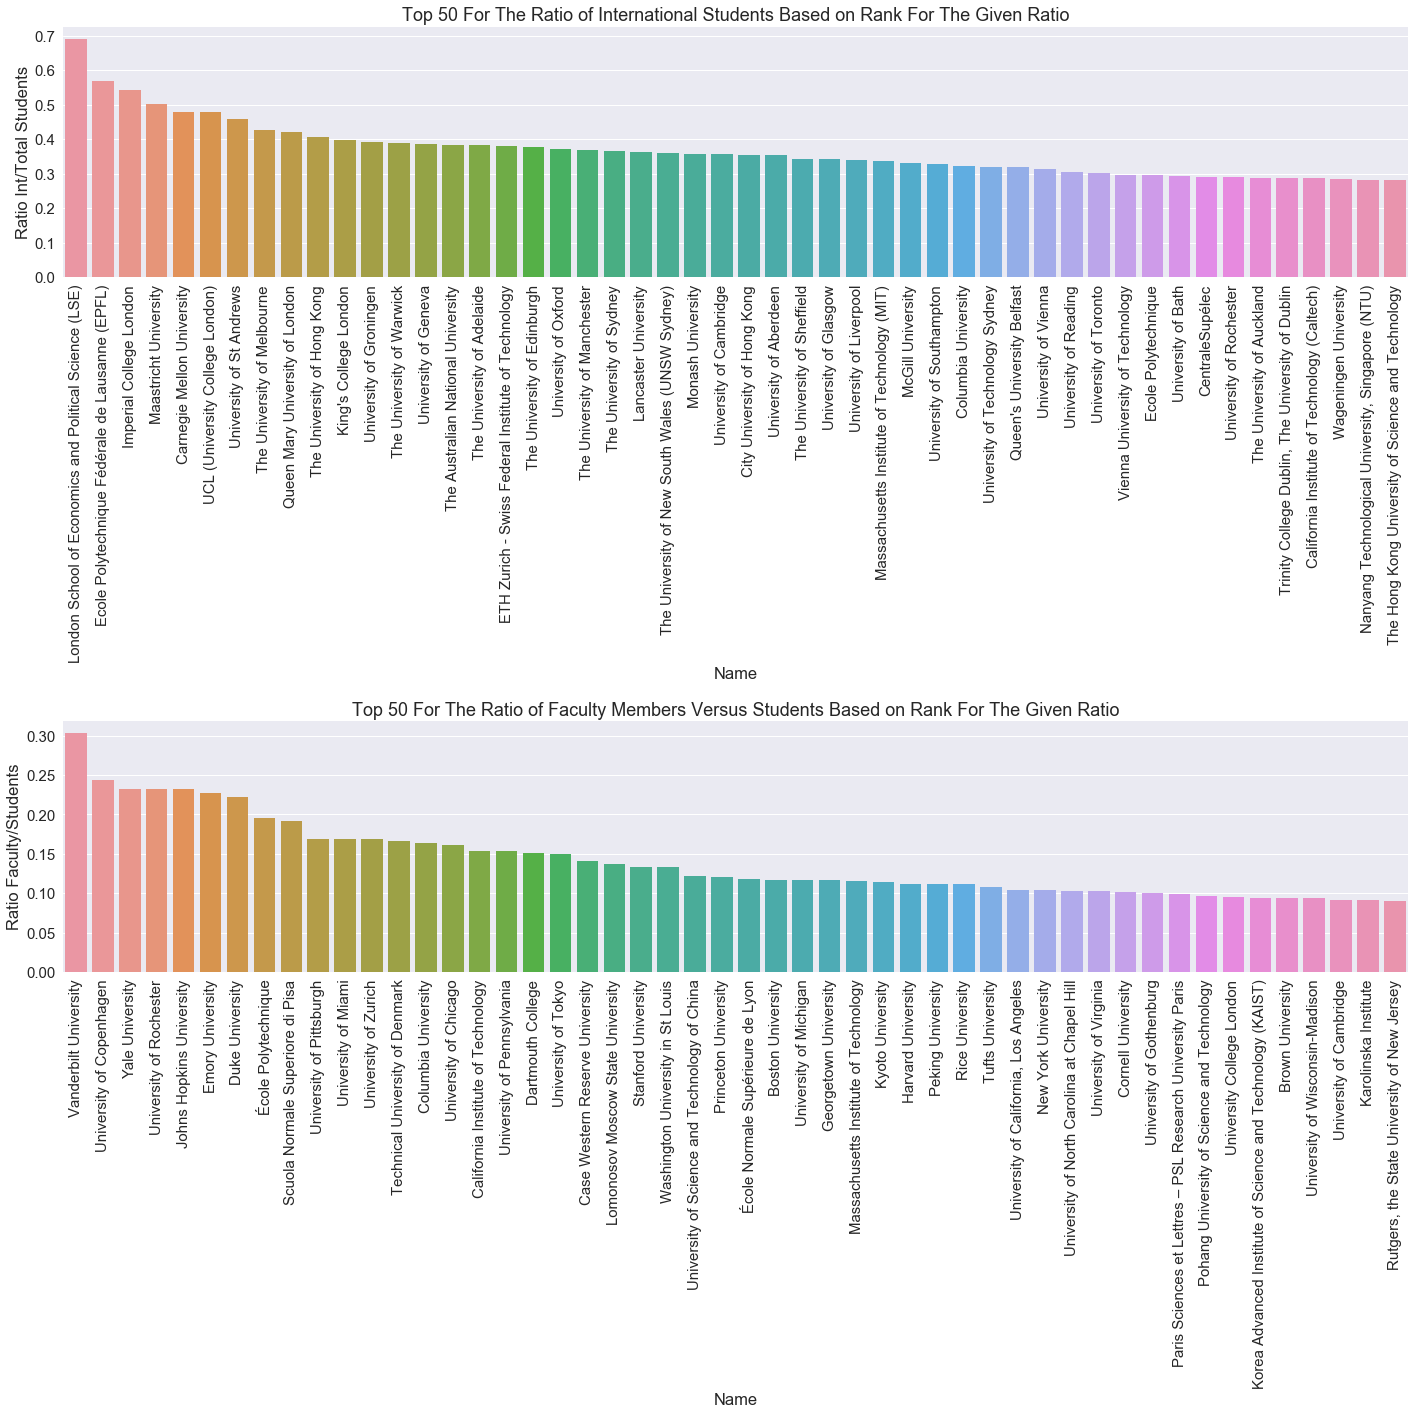

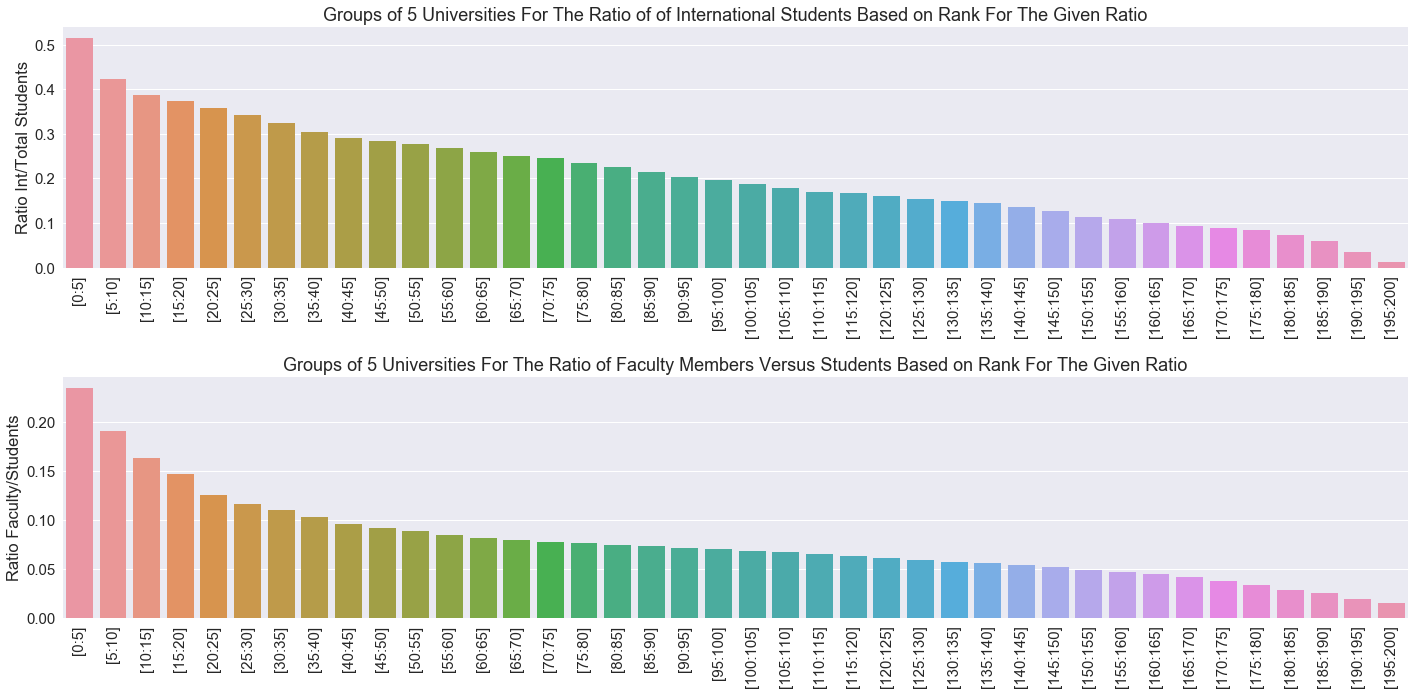

In [24]:
fig = plt.figure(figsize  = (20,20))

plt.subplot(211)
plot = sns.barplot(ratio_int_students.head(50).index,ratio_int_students['Ratio Int/Total Students'].head(50))
plot.set_xticklabels(ratio_int_students.index,rotation=90)
plt.title("Top 50 For The Ratio of International Students Based on Rank For The Given Ratio")

plt.subplot(212)
plot = sns.barplot(ratio_fac_students.head(50).index,ratio_fac_students['Ratio Faculty/Students'].head(50))
plot.set_xticklabels(ratio_fac_students.index,rotation=90)
plt.title("Top 50 For The Ratio of Faculty Members Versus Students Based on Rank For The Given Ratio")

fig.tight_layout()


fig = plt.figure(figsize  = (20,10))

plt.subplot(211)
plot_groupby_rank(5, ratio_int_students,'Ratio Int/Total Students')
plt.title("Groups of 5 Universities For The Ratio of of International Students Based on Rank For The Given Ratio")

plt.subplot(212)
plot_groupby_rank(5, ratio_fac_students,'Ratio Faculty/Students')
plt.title("Groups of 5 Universities For The Ratio of Faculty Members Versus Students Based on Rank For The Given Ratio")

fig.tight_layout()

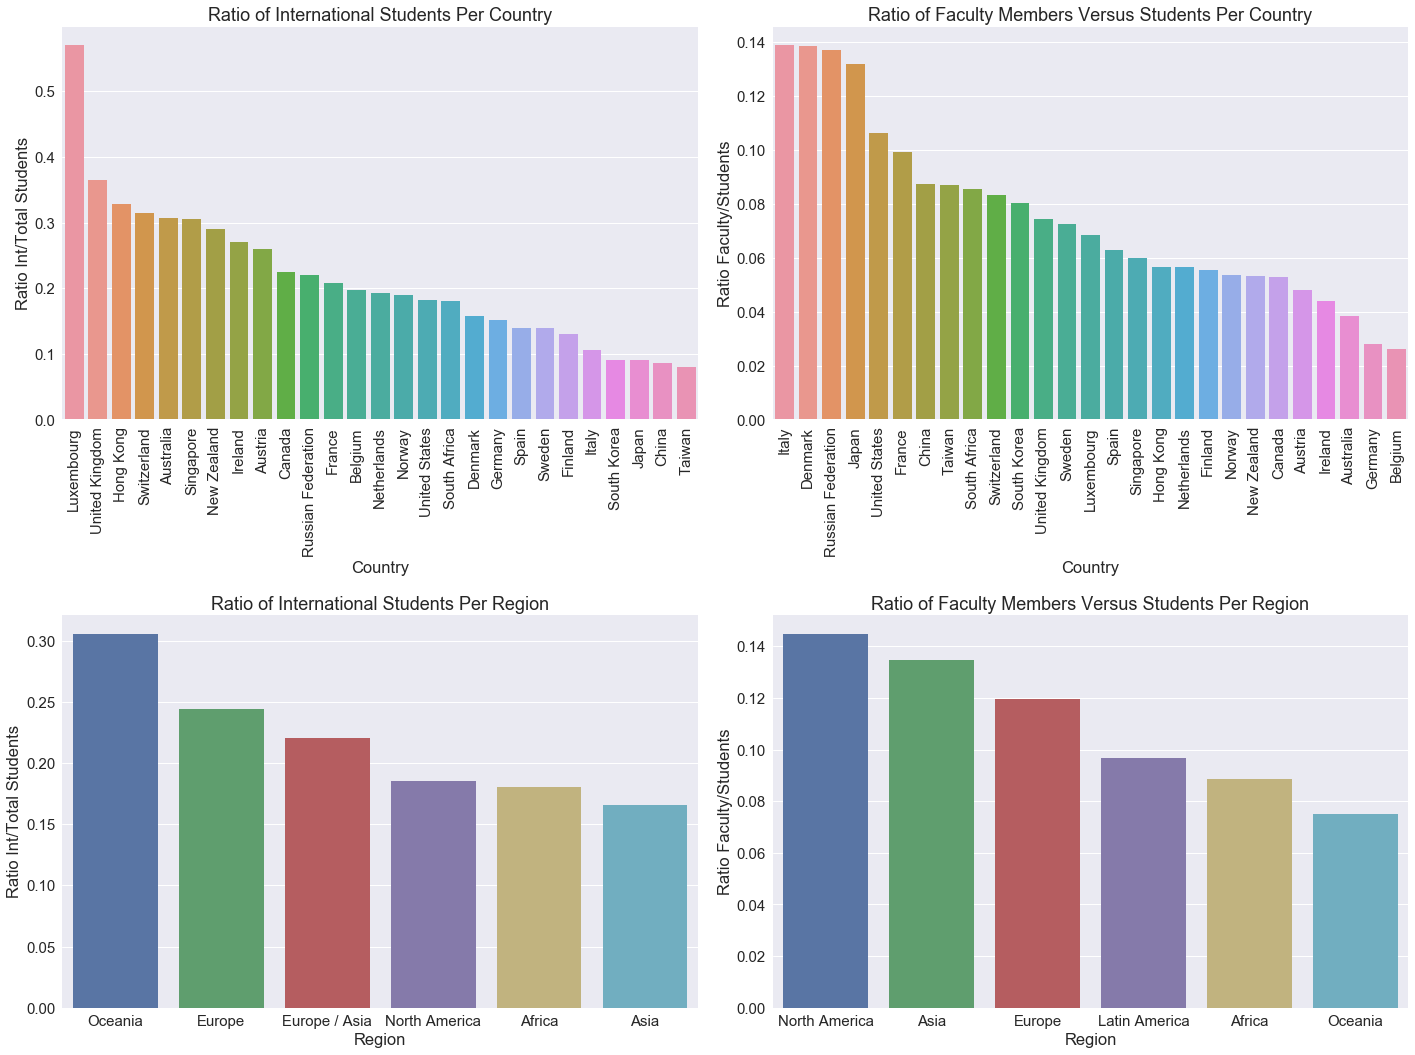

In [25]:
fig = plt.figure(figsize  = (20,15))
plt.subplot(221)
plot = sns.barplot(country_rank_int_total_students.index,country_rank_int_total_students["Ratio Int/Total Students"])
plot.set_xticklabels(country_rank_int_total_students.index,rotation=90)
plt.title("Ratio of International Students Per Country")

plt.subplot(222)
plot = sns.barplot(country_rank_fac_students.index,country_rank_fac_students["Ratio Faculty/Students"])
plot.set_xticklabels(country_rank_fac_students.index,rotation=90)
plt.title("Ratio of Faculty Members Versus Students Per Country")

plt.subplot(223)
sns.barplot(region_int_total_students.index,region_int_total_students["Ratio Int/Total Students"])
plt.title("Ratio of International Students Per Region")

plt.subplot(224)
sns.barplot(region_fac_students.index,region_fac_students["Ratio Faculty/Students"])
plt.title("Ratio of Faculty Members Versus Students Per Region")
fig.tight_layout()

### Observations

The stats are quite similar to what was observed with the QS ranking : 
- LSE and EPFL have high international presence
- The top universities where ratio of faculty vs students is concerned is no longer Caltech and Yale but Vanderbilt and the university of copenhagen with Yale not far behing
- Luxemberg is now the number one in terms of international students. This is due to the fact that it was not present in the QS ranking. The UK is still present with Switzerland not far behind.
- Italy, Denmark and Russia are number one in terms of faculty with Saudi Arabia nowhere in sight. 
- The regional statistics show the same rankings. 

Globally the results are the same with minor variations due to the fact that the figures are not exactly the same on both websites and that the universities in the THE and QS rankings are not the same. 

# Pickling the dataframes

Pickle the dataframes for each of the ranking websites

In [26]:
ranking_QS.to_pickle('ranking_QS.pickle')
ranking_THE.to_pickle('ranking_THE.pickle')

Load the dataframes for each of the ranking websites from pickle

In [67]:
ranking_QS = pd.read_pickle('ranking_QS.pickle')
ranking_THE = pd.read_pickle('ranking_THE.pickle')

# 3. Merging the DataFrames

The objective here is to merge the dataframes based on the university names. Most of the time the university name is written the same way in both ranking websites. The rest of the time however, the acronyms are added in the string. That is why the idea here was to use the string edition distance or Levenshtein distance to compare the strings one to one. The smallest distance when comparing all the names of the different rankings would therefore correspond to the most likely university 

## 3.1. Identifying Universities in Both Rankings Based On Names

Looking at the university names when the string edition distance was not 0, i.e. if the strings were not exactly the same, we noticed that a few modifications to the strings would help get a better estimate of the string edition distance : 
- Remove or replace odd characters
- Convert everything to lower case
- Remove the word university and all it's translations to avoid the problems of multiple languages

The other thing we noticed was that the acronyms were often either in the begining or the end of the string. Therefore we could check to see if the names of the universities were mutually included. If one of the names is in the other, that is most likely because they are the same. We manually checked that that was the case for all the universities which met the condition. 

This function is used to format the strings of university names by replacing odd characters and removing the word university and all its translations. The entire string is also set to lower case. This helps makes the strings more easily comparable.

In [68]:
def format_string(string):
    # Remove Problematic characters which do not hold relevant information
    string = string.replace("–", "-").replace("-", " ").replace("’","'")
    string = string.replace(".", "").replace(",", "").replace("&", "and").replace(" and ", " ")
    string = string.replace("(", "").replace(")", "")
    
    # Convert to lower case for uniformity 
    string = string.lower()
    
    # Remove sepcial characters 
    string = string.replace("é","e")
    
    # Handling the issues with university and it's translations
    string = re.sub('univers.*? ', '', string) 
    string = re.sub(r'\b\w{1,2}\b', '', string)
    string = re.sub('university', '', string) # Necessary when university is at the start or end of the string
    string = string.replace("  ", " ")
    
    return string

This function is used to find the names with the smallest edition distance in both rankings. The edition distance is the minimum number of single-character edits which need to be made to a string so that it is equal to another one (also known as Levenshtein distance). This includes addition, substitution and deletion. For example the edition distance between 'Northeastern' and 'Northwestern' is equal to 2 as one only needs to remove the 'w' and add an 'a' to transform Northwestern into Northeastern. Another example would be to compute the edition distance between 'London School of Economics (LSE)' and 'London School of Economics'. In this case te edition distance is equal to 6 as one would need to remove ' (LSE)' so that both strings be equal. 

The edition distance is computed using the editdistance function from an external library which computes the Levenstein distance between two strings in under $10 \mu s$. It also takes into account the transposition of two adjacent characters which is common in typed texts.  

If the distance is 0 or if on of the strings is included in the other, then they are the same. Otherwise they are considered as different. This is necessary as certain universities only had 2 characters which differed in their names. It is therefore not possible to set a threshold above 0 for the edition distance. The remaining closest pairs then need to be checked manually. 

In [69]:
def find_equivalent_of_r1_in_r2(r1,r2):
    # Initialise a dictionary with the names of universities for which an equivalent was found in both rankings
    found_dict = {}
    # Initialise a dictionary with the names of universities for which no equivalent was found
    not_found_dict = {}
    # For all the names in the first ranking, format the string and init an array for the edition distance
    for name1 in r1.Name.tolist():
        name1_f= format_string(name1)
        distance = []
        # Go through all the names in the second ranking and compute the edition distance using the editdist library
        for name2 in r2.Name.tolist():
            name2_f= format_string(name2)
            distance.append(editdistance.eval(name2_f, name1_f)) 
        # Get name2 with the smallest edition distance to name 1 and format it
        min_dist = min(distance)
        name_found = r2.Name.iloc[distance.index(min_dist)]
        name_found_f = format_string(name_found)
        condition = (name1_f in name_found_f) or (name_found_f in name1_f)
        # Append to the correct dictionary based on edition distance and inclusion criterion.
        if min_dist == 0 or condition:
            found_dict.update({name1: name_found})
        else :
            not_found_dict.update({name1: name_found})
    return found_dict,not_found_dict

In [70]:
THE_to_QS, THE_not_in_QS = find_equivalent_of_r1_in_r2(ranking_THE,ranking_QS)
QS_to_THE, QS_not_in_THE = find_equivalent_of_r1_in_r2(ranking_QS,ranking_THE)

The universities which met the suss-mentioned conditions were considered as the same. The others then had to be verified manually as the edition distance is not sufficient to determine whether the names correspond to the same university or not. ex : university of bergen  =  university of bern with a string edition distance of 2 whereas ecole polytechnique federale de lausanne (epfl)  =  école polytechnique federale de lausanne with a string edition distance of 8. 

Note that we manually checked that the strings which were identified were the same actually coresponded to the same universities. 

Looking at the univiersities that are in the THE ranking but not in the QS ranking we find a few univerisities which were not identified as being the same : 
- 'Autonomous University of Barcelona': 'Universitat Autònoma de Barcelona'
- 'Free University of Berlin': 'Freie Universitaet Berlin'

Doing the same for the universities in QS but not in THE we find the same 4 which were not identified: 
- 'Universitat Autònoma de Barcelona': 'Autonomous University of Barcelona'
- 'Freie Universitaet Berlin': 'Free University of Berlin'

A few new ones were equally noted : 
- 'KAIST - Korea Advanced Institute of Science & Technology': 'Korea Advanced Institute of Science and Technology (KAIST)'
- 'Pohang University of Science And Technology (POSTECH)': 'Pohang University of Science and Technology'
- 'Technische Universität Berlin (TU Berlin)': 'Technical University of Berlin'


Therefore we took the 7 missing universities and added them to a final dictionary which contains the QS names as keys and the THE names as values. 

In [71]:
QS_to_THE.update({'Universitat Autònoma de Barcelona': 'Autonomous University of Barcelona'})
QS_to_THE.update({'Freie Universitaet Berlin': 'Free University of Berlin'})
QS_to_THE.update({'KAIST - Korea Advanced Institute of Science & Technology': 'Korea Advanced Institute of Science and Technology (KAIST)'})
QS_to_THE.update({'Pohang University of Science And Technology (POSTECH)': 'Pohang University of Science and Technology'})
QS_to_THE.update({'Technische Universität Berlin (TU Berlin)': 'Technical University of Berlin'})

del QS_not_in_THE['Universitat Autònoma de Barcelona']
del QS_not_in_THE['Freie Universitaet Berlin']
del QS_not_in_THE['KAIST - Korea Advanced Institute of Science & Technology']
del QS_not_in_THE['Pohang University of Science And Technology (POSTECH)']
del QS_not_in_THE['Technische Universität Berlin (TU Berlin)']

del THE_not_in_QS['Autonomous University of Barcelona']
del THE_not_in_QS['Free University of Berlin']

In [72]:
# Set Index for both rankings
ranking_QS = ranking_QS.set_index('Name')
ranking_THE = ranking_THE.set_index('Name')

## 3.2. Combining the Dataframes 

In [73]:
# This function is used to extract specific column information for given university names from the 
# website dataframe. 
def extract_info_for_name(site_name,website_df, names, infos):
    df = pd.DataFrame(columns = infos)
    df[('Name '+site_name)] = names
    for info in infos:
        df[info] = website_df.loc[names,info].tolist()
    return df

To merge all the results into one dataframe we started by recovering the names of the universities in both rankings. We selected the information we wanted to keep from either ranking. We decided to keep the number of faculty members and students from the QS ranking as all the information was given, none had to be estimated. This of course when the university was in both rankings. In the case where the university was only in the THE ranking, the information was taken from the THE dataframe. We combined the names of the universities from both rankings by keeping the QS name if it was present and replacing it by the THE otherwise. Once this was done the resulting Name column was set as index. We easily check that everything went well by observing the dataframe column names and values

In [74]:
# Names in Both Rankings
NameQS = list(QS_to_THE.keys())
NameTHE = list(QS_to_THE.values()) 

# The information we want to extract from each dataframe
infos_QS = ['Country','Region', 'Rank',\
            'Number of faculty members (int)',\
            'Number of faculty members (total)',\
            'Number of students (int)','Number of students (total)']
infos_THE = ['Rank']

# Extracting and merging
df_QS = extract_info_for_name("QS",ranking_QS, NameQS, infos_QS)
df_QS = df_QS.rename(columns={'Rank': 'Rank QS'})
df_THE = extract_info_for_name("THE", ranking_THE, NameTHE,infos_THE)
df_THE = df_THE.rename(columns={'Rank': 'Rank THE'})
combined_df = pd.concat([df_QS, df_THE], axis=1, join_axes=[df_QS.index])

# Adding information for universities in one ranking but not in the other
names = [list(QS_not_in_THE.keys()), list(THE_not_in_QS.keys())]
site_dfs = [ranking_QS, ranking_THE]
site_name = ['QS', 'THE']

for univ_names, df, site in zip(names, site_dfs, site_name):
    temp_df = df[infos_QS].loc[univ_names]
    temp_df = temp_df.reset_index()
    temp_df = temp_df.rename(columns={'Rank': ('Rank '+ site), \
                                      'Name' : ('Name '+ site)})
    # Combining the intermediate dataframe with the result
    combined_df = combined_df.append(temp_df, ignore_index=True)

# For the universities not in both rankings, fill the QS column with the THE name
combined_df['Name QS'].fillna(combined_df['Name THE'], inplace = True)
# Rename the Name QS column to Name
combined_df.rename(columns={'Name QS': 'Name'}, inplace = True)
# Delete the Name THE column
combined_df.drop(['Name THE'], axis = 1, inplace = True)
# Set the final name as index
combined_df.set_index('Name', inplace = True)

combined_df.head(10)

,Country,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Rank QS,Rank THE,Region
Name,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679.0,2982.0,3717.0,11067.0,1.0,5.0,North America
Stanford University,United States,2042.0,4285.0,3611.0,15878.0,2.0,3.0,North America
Harvard University,United States,1311.0,4350.0,5266.0,22429.0,3.0,6.0,North America
California Institute of Technology (Caltech),United States,350.0,953.0,647.0,2255.0,4.0,3.0,North America
University of Cambridge,United Kingdom,2278.0,5490.0,6699.0,18770.0,5.0,2.0,Europe
University of Oxford,United Kingdom,2964.0,6750.0,7353.0,19720.0,6.0,1.0,Europe
UCL (University College London),United Kingdom,2554.0,6345.0,14854.0,31080.0,7.0,16.0,Europe
Imperial College London,United Kingdom,2071.0,3930.0,8746.0,16090.0,8.0,8.0,Europe
University of Chicago,United States,635.0,2449.0,3379.0,13557.0,9.0,9.0,North America


In [75]:
combined_df

,Country,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Rank QS,Rank THE,Region
Name,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679.0,2982.0,3717.0,11067.0,1.0,5.0,North America
Stanford University,United States,2042.0,4285.0,3611.0,15878.0,2.0,3.0,North America
Harvard University,United States,1311.0,4350.0,5266.0,22429.0,3.0,6.0,North America
California Institute of Technology (Caltech),United States,350.0,953.0,647.0,2255.0,4.0,3.0,North America
University of Cambridge,United Kingdom,2278.0,5490.0,6699.0,18770.0,5.0,2.0,Europe
University of Oxford,United Kingdom,2964.0,6750.0,7353.0,19720.0,6.0,1.0,Europe
UCL (University College London),United Kingdom,2554.0,6345.0,14854.0,31080.0,7.0,16.0,Europe
Imperial College London,United Kingdom,2071.0,3930.0,8746.0,16090.0,8.0,8.0,Europe
University of Chicago,United States,635.0,2449.0,3379.0,13557.0,9.0,9.0,North America


## 3.3 Combining Dataframe by keeping all the informations for both rankings
Here we proceed the same way as in the previous section, only we keep all the variables of all the ranking. We do this in order to be able to compare the 2 rankings and see if the inconsistencies in the data can correlate with any of the other variables in question 4

In [76]:
# The information we want to extract from each dataframe
col_kept_in_both = [ 'Rank',\
            'Number of faculty members (int)',\
            'Number of faculty members (total)',\
            'Number of students (int)','Number of students (total)']

# Extracting and merging
df_QS = extract_info_for_name("QS",ranking_QS, NameQS, infos_QS)
rename_dict = dict(zip(col_kept_in_both,[ col + ' QS'  for col in df_QS[col_kept_in_both].columns]))
df_QS.rename(columns =rename_dict, inplace = True)

df_THE = extract_info_for_name("THE", ranking_THE, NameTHE,col_kept_in_both)
rename_dict = dict(zip(col_kept_in_both,[ col + ' THE' for col in df_THE[col_kept_in_both].columns]))
df_THE.rename(columns=rename_dict, inplace=True)

combined_all_df = pd.concat([df_QS, df_THE], axis=1, join_axes=[df_QS.index])

combined_all_df.head(10)

,Country,Region,Rank QS,Number of faculty members (int) QS,Number of faculty members (total) QS,Number of students (int) QS,Number of students (total) QS,Name QS,Rank THE,Number of faculty members (int) THE,Number of faculty members (total) THE,Number of students (int) THE,Number of students (total) THE,Name THE
0,United States,North America,1,1679.0,2982.0,3717.0,11067.0,Massachusetts Institute of Technology (MIT),5,NaN,1285,3800,11177,Massachusetts Institute of Technology
1,United States,North America,2,2042.0,4285.0,3611.0,15878.0,Stanford University,3,NaN,2113,3486,15845,Stanford University
2,United States,North America,3,1311.0,4350.0,5266.0,22429.0,Harvard University,6,NaN,2284,5285,20326,Harvard University
3,United States,North America,4,350.0,953.0,647.0,2255.0,California Institute of Technology (Caltech),3,NaN,340,596,2209,California Institute of Technology
4,United Kingdom,Europe,5,2278.0,5490.0,6699.0,18770.0,University of Cambridge,2,NaN,1687,6436,18389,University of Cambridge
5,United Kingdom,Europe,6,2964.0,6750.0,7353.0,19720.0,University of Oxford,1,NaN,1822,7755,20409,University of Oxford
6,United Kingdom,Europe,7,2554.0,6345.0,14854.0,31080.0,UCL (University College London),16,NaN,2886,14849,30304,University College London
7,United Kingdom,Europe,8,2071.0,3930.0,8746.0,16090.0,Imperial College London,8,NaN,1391,8721,15857,Imperial College London
8,United States,North America,9,635.0,2449.0,3379.0,13557.0,University of Chicago,9,NaN,2181,3381,13525,University of Chicago
9,Switzerland,Europe,10,1886.0,2477.0,7563.0,19815.0,ETH Zurich - Swiss Federal Institute of Techno...,10,NaN,1317,7309,19233,ETH Zurich – Swiss Federal Institute of Techno...


# 4. Insights in the data by performing an exploratory analysis

## 4.1. Analysing The Overall Dataframe 

## TODO : add Jordi's variables here

The first step was to add the ratio faculty vs students, international vs. total students and international vs. total faculty. 

In [77]:
expl_result = combined_df.copy()

# Re-Compute the statistics with the final dataframe
expl_result['Ratio Faculty/Students'] = combined_df['Number of faculty members (total)']/combined_df['Number of students (total)']
expl_result['Ratio Int/Tot Students'] = combined_df['Number of students (int)']/combined_df['Number of students (total)']
expl_result['Ratio Int/Tot Faculty'] = combined_df['Number of faculty members (int)']/combined_df['Number of faculty members (total)']
expl_result['Ratio Int/Tot'] = (combined_df['Number of students (int)']+combined_df['Number of faculty members (int)'])/(combined_df['Number of students (total)']+combined_df['Number of faculty members (total)'])

# Adding new variables to compute statistics




expl_result.head()

,Country,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Rank QS,Rank THE,Region,Ratio Faculty/Students,Ratio Int/Tot Students,Ratio Int/Tot Faculty,Ratio Int/Tot
Name,,,,,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679.0,2982.0,3717.0,11067.0,1.0,5.0,North America,0.269450,0.335863,0.563045,0.384084
Stanford University,United States,2042.0,4285.0,3611.0,15878.0,2.0,3.0,North America,0.269870,0.227422,0.476546,0.280365
Harvard University,United States,1311.0,4350.0,5266.0,22429.0,3.0,6.0,North America,0.193945,0.234785,0.301379,0.245603
California Institute of Technology (Caltech),United States,350.0,953.0,647.0,2255.0,4.0,3.0,North America,0.422616,0.286918,0.367261,0.310786
University of Cambridge,United Kingdom,2278.0,5490.0,6699.0,18770.0,5.0,2.0,Europe,0.292488,0.356899,0.414936,0.370033


To verify which data follows a normal distribution we computed the normal test using the scipy library. If the obtained p-value was above 0.05 then the data came from a normal distribution. Otherwise it was not normal. 

In [78]:
# Convert country and region to categorical codes to be able  to compute correlation on them
categ_results = expl_result.copy()

categ_results["Country"] = categ_results["Country"].astype('category')
categ_results["Region"] = categ_results["Region"].astype('category')

categ_results["Country"] = categ_results["Country"].cat.codes.tolist()
categ_results["Region"] = categ_results["Region"].cat.codes.tolist()

for categ in list(combined_df):
    test = scipy.stats.normaltest(expl_result['Number of students (total)'].dropna().tolist())
    if test[1]>0.05:
        print(categ,": Normal Distribution")
    else:
        print(categ,": NOT Normal Distribution")

Country : NOT Normal Distribution
Number of faculty members (int) : NOT Normal Distribution
Number of faculty members (total) : NOT Normal Distribution
Number of students (int) : NOT Normal Distribution
Number of students (total) : NOT Normal Distribution
Rank QS : NOT Normal Distribution
Rank THE : NOT Normal Distribution
Region : NOT Normal Distribution


Evidentely the data does not follow a normal distribution. We cannot use parametric tests to analyze the data. We need to rely on non parametric statistics such as quartiles and medians or other more sophisticated non parametric tests such as spearman correlation to determine the pairwise correlation between all the variables.

In [79]:
categ_results.describe()

,Country,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Rank QS,Rank THE,Region,Ratio Faculty/Students,Ratio Int/Tot Students,Ratio Int/Tot Faculty,Ratio Int/Tot
count,251.000000,199.000000,250.000000,250.000000,250.000000,201.000000,207.000000,251.000000,250.000000,250.000000,199.000000,199.000000
mean,22.155378,786.311558,2577.868000,4793.928000,24865.528000,100.751244,99.724638,2.549801,0.114332,0.205963,0.284907,0.220379
std,11.639406,665.006382,1971.893823,3740.794007,16709.611681,58.072608,57.485553,1.200212,0.062556,0.114578,0.171144,0.117265
min,0.000000,1.000000,59.000000,47.000000,532.000000,1.000000,1.000000,0.000000,0.012830,0.009892,0.008403,0.010575
25%,11.000000,330.000000,1245.000000,2174.250000,13485.750000,51.000000,51.000000,2.000000,0.073525,0.123716,0.147335,0.132055
50%,27.000000,602.000000,2315.000000,4091.000000,22424.000000,101.000000,98.000000,2.000000,0.104402,0.181652,0.280047,0.208831
75%,33.000000,1027.500000,3360.000000,6334.000000,32184.000000,151.000000,147.000000,4.000000,0.140359,0.277010,0.389342,0.291036
max,34.000000,3905.000000,16421.000000,27109.000000,141939.000000,202.000000,201.000000,5.000000,0.422616,0.691393,0.766962,0.685380


## TODO : Commenter les moyennes medianes etc...
Computing average ranks per region to see if there is a correlation with other variables

In [80]:
mean_reg = expl_result[['Rank QS', 'Rank THE', 'Region']].groupby('Region').mean()
mean_reg.rename(columns={'Rank QS': 'Region Mean Rank QS', 'Rank THE': 'Region Mean Rank THE'}, inplace=True)
mean_reg.reset_index(inplace = True)
expl_result = pd.merge(expl_result.reset_index().copy(), mean_reg, on='Region').set_index("Name")
expl_result.head()

,Country,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Rank QS,Rank THE,Region,Ratio Faculty/Students,Ratio Int/Tot Students,Ratio Int/Tot Faculty,Ratio Int/Tot,Region Mean Rank QS,Region Mean Rank THE
Name,,,,,,,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679.0,2982.0,3717.0,11067.0,1.0,5.0,North America,0.269450,0.335863,0.563045,0.384084,81.092593,74.0
Stanford University,United States,2042.0,4285.0,3611.0,15878.0,2.0,3.0,North America,0.269870,0.227422,0.476546,0.280365,81.092593,74.0
Harvard University,United States,1311.0,4350.0,5266.0,22429.0,3.0,6.0,North America,0.193945,0.234785,0.301379,0.245603,81.092593,74.0
California Institute of Technology (Caltech),United States,350.0,953.0,647.0,2255.0,4.0,3.0,North America,0.422616,0.286918,0.367261,0.310786,81.092593,74.0
University of Chicago,United States,635.0,2449.0,3379.0,13557.0,9.0,9.0,North America,0.180645,0.249244,0.259290,0.250781,81.092593,74.0


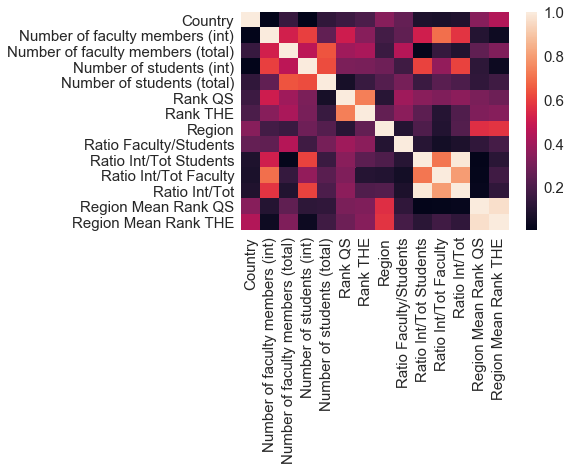

In [81]:
categ_results["Region Mean Rank QS"] = expl_result["Region Mean Rank QS"]
categ_results["Region Mean Rank THE"] = expl_result["Region Mean Rank THE"]

corr = categ_results.corr(method='spearman').abs()
sns.heatmap(corr, yticklabels=categ_results.columns)

Looking at the absolute value of the correlations between all variables : 
- The only thing correlated with the ranks are the ranks... This shows that there is a consensus between the two ranking systems but that none of the variables above seem to have significant influence. The parameters here do not seem to influence the rank. The rank therefore depends on other criterion which are not provided.
- The ratio of international students and the ratio of international faculty are highly correlated. The universities which are "international" have both high ratios of international students and faculty members. 
- Number of students and number of international students are mildly correlated. This means that in general, universities with a lot of students tend to have more international students.
- Countries and regions are not correlated with anything


## 4.2. Looking For Correlations With the Inconsistencies

,Country,Region,Rank QS,Number of faculty members (total) QS,Number of students (int) QS,Number of students (total) QS,Rank THE,Number of faculty members (total) THE,Number of students (int) THE,Number of students (total) THE,Difference faculty tot,Difference students int,Difference students tot
0,25,3,1,2982.0,3717.0,11067.0,5,1285,3800,11177,1697.0,-83.0,-110.0
1,25,3,2,4285.0,3611.0,15878.0,3,2113,3486,15845,2172.0,125.0,33.0
2,25,3,3,4350.0,5266.0,22429.0,6,2284,5285,20326,2066.0,-19.0,2103.0
3,25,3,4,953.0,647.0,2255.0,3,340,596,2209,613.0,51.0,46.0
4,24,2,5,5490.0,6699.0,18770.0,2,1687,6436,18389,3803.0,263.0,381.0


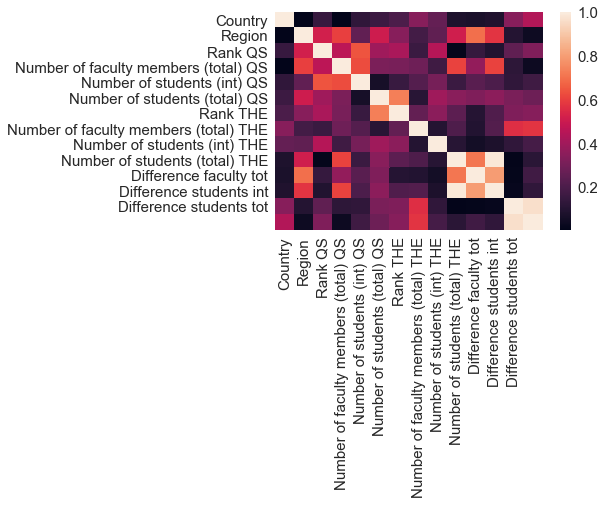

In [98]:
inconsistencies_df = combined_all_df.copy()
inconsistencies_df['Difference faculty tot'] = inconsistencies_df['Number of faculty members (total) QS']\
                                             - inconsistencies_df['Number of faculty members (total) THE']
inconsistencies_df['Difference students int'] = inconsistencies_df['Number of students (int) QS']\
                                             - inconsistencies_df['Number of students (int) THE']
inconsistencies_df['Difference students tot'] = inconsistencies_df['Number of students (total) QS']\
                                             - inconsistencies_df['Number of students (total) THE']

inconsistencies_df["Country"] = inconsistencies_df["Country"].astype('category')
inconsistencies_df["Region"] = inconsistencies_df["Region"].astype('category')

inconsistencies_df["Country"] = inconsistencies_df["Country"].cat.codes.tolist()
inconsistencies_df["Region"] = inconsistencies_df["Region"].cat.codes.tolist()

inconsistencies_df.drop(['Name QS'], axis = 1, inplace = True)
inconsistencies_df.drop(['Name THE'], axis = 1, inplace = True)
inconsistencies_df.drop(['Number of faculty members (int) THE'], axis = 1, inplace = True)
inconsistencies_df.drop(['Number of faculty members (int) QS'], axis = 1, inplace = True)

corr_inconst = inconsistencies_df.corr(method='spearman').abs()
sns.heatmap(corr, xticklabels=inconsistencies_df.columns,
            yticklabels=inconsistencies_df.columns)
inconsistencies_df.head()

# 5. Selecting the Best University

BLABLABLABLABLA

## 5.1. Trivial Approach

A trivial solution would be to take the average ranking and find the university with the smallest resulting ranking. Using this method **Stanford** would come out as the best university. 

In [83]:
combined_df['Mean Rank'] = (combined_df['Rank THE'] + combined_df['Rank QS'])/2
idx_min = combined_df['Mean Rank'].idxmin()
combined_df.loc[idx_min]

Country                              United States
Number of faculty members (int)               2042
Number of faculty members (total)             4285
Number of students (int)                      3611
Number of students (total)                   15878
Rank QS                                          2
Rank THE                                         3
Region                               North America
Mean Rank                                      2.5
Name: Stanford University, dtype: object

## 5.2. Selection by Elimination

The best university must be in the top 7 of both rankings. Therefore we can already isolate the universities which have both rankings below 7. We filter at 7 to be sure to keep the top universities. 

In [84]:
top_7 = combined_df.loc[(combined_df['Rank QS'] <= 7) & (combined_df['Rank THE'] <= 7)]
top_7

,Country,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Rank QS,Rank THE,Region,Mean Rank
Name,,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679.0,2982.0,3717.0,11067.0,1.0,5.0,North America,3.0
Stanford University,United States,2042.0,4285.0,3611.0,15878.0,2.0,3.0,North America,2.5
Harvard University,United States,1311.0,4350.0,5266.0,22429.0,3.0,6.0,North America,4.5
California Institute of Technology (Caltech),United States,350.0,953.0,647.0,2255.0,4.0,3.0,North America,3.5
University of Cambridge,United Kingdom,2278.0,5490.0,6699.0,18770.0,5.0,2.0,Europe,3.5
University of Oxford,United Kingdom,2964.0,6750.0,7353.0,19720.0,6.0,1.0,Europe,3.5


Looking at the list we can see that MIT is 1st in QS, 5th  in THE and that Oxford is first in THE but 6th in QS. Therefore we could consider that the best university would be one where both rankings would be in agreement. Therefore we could filter and only keep universities where the difference in rank is smaller than 3

In [85]:
consensus = top_7.loc[(abs(top_7['Rank QS']-top_7['Rank THE']) < 3)]
consensus

,Country,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Rank QS,Rank THE,Region,Mean Rank
Name,,,,,,,,,
Stanford University,United States,2042.0,4285.0,3611.0,15878.0,2.0,3.0,North America,2.5
California Institute of Technology (Caltech),United States,350.0,953.0,647.0,2255.0,4.0,3.0,North America,3.5


Here we see that we have only 2 universities left. Stanford has a better ranking than Caltech in the QS rank, the THE rank is the same for both universities. Therfore we can consider that the best university is **Stanford**. This corresponds to what we found by just taking the minimum average rank. 